In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
!pip install scikit-plot
#import scikitplot as skplt
!pip install scikit-learn
from sklearn.datasets import make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OutputCodeClassifier
from sklearn.metrics import f1_score,fbeta_score,matthews_corrcoef, log_loss, confusion_matrix, classification_report, make_scorer, balanced_accuracy_score, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV,learning_curve
from lightgbm import LGBMClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.preprocessing import (OneHotEncoder,PowerTransformer,StandardScaler)
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier

In [74]:
#!pip install pyxlsb
from google.colab import files
uploaded=files.upload()
filepath=list(uploaded.keys())[0]
df = pd.read_csv(filepath)


Saving dataset.csv to dataset (2).csv


PREPROCESSING DATA

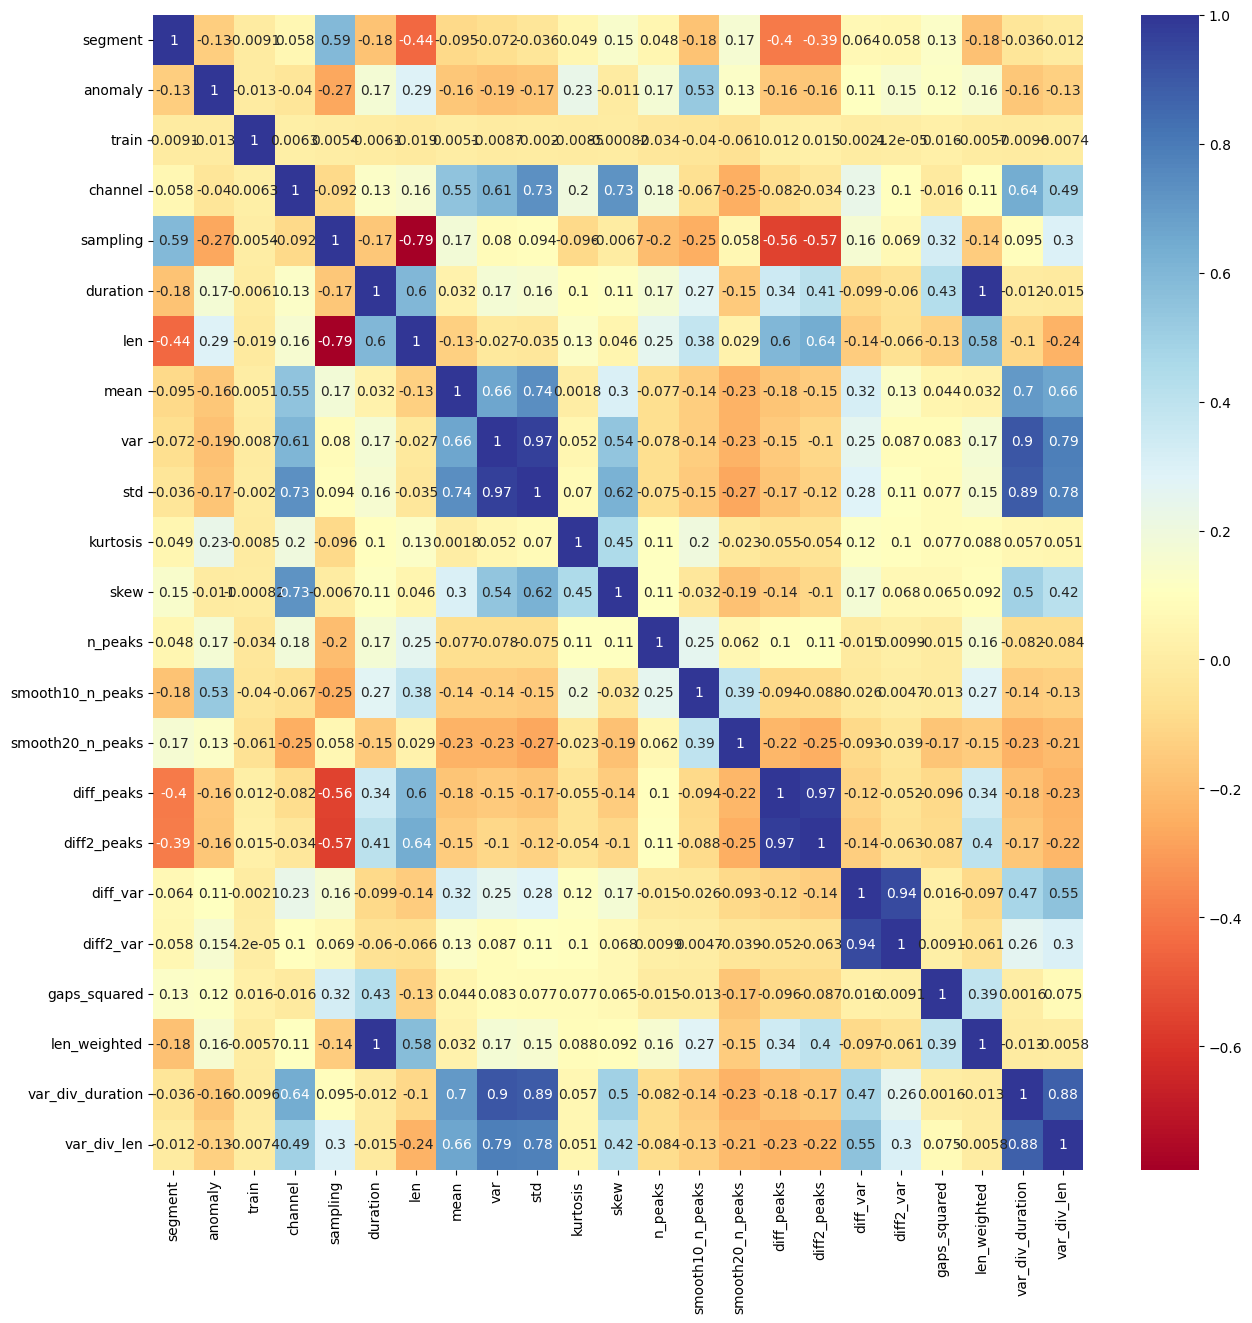

In [75]:
from sklearn.preprocessing import LabelEncoder
label_encoders = {}
for col in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df['channel'])
    label_encoders[col] = le

plt.figure(figsize=(15,15))
sns.heatmap(df.corr(),annot=True,cmap='RdYlBu')
plt.draw()


In [76]:
df['channel'].head()

,channel
0,0
1,0
2,0
3,0
4,0


In [77]:
df.isnull().values.any()

np.False_

In [78]:
df.describe()

,segment,anomaly,train,channel,sampling,duration,len,mean,var,std,...,smooth10_n_peaks,smooth20_n_peaks,diff_peaks,diff2_peaks,diff_var,diff2_var,gaps_squared,len_weighted,var_div_duration,var_div_len
count,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2123.000000,2.123000e+03,2.123000e+03,2123.000000,...,2123.000000,2123.000000,2123.000000,2123.000000,2.123000e+03,2.123000e+03,2123.000000,2123.000000,2.123000e+03,2.123000e+03
mean,1062.000000,0.204428,0.750824,2.577485,3.505888,267.952426,142.954781,1.109677e-01,3.065868e-02,0.096226,...,1.110221,1.181818,18.110692,25.286387,9.166359e-04,1.045846e-03,1027.671691,267.925106,1.159496e-04,4.361427e-04
std,613.001631,0.403378,0.432638,2.678325,1.935418,169.093207,152.329786,1.963165e-01,5.491161e-02,0.146319,...,0.399227,0.425295,28.991979,32.737797,4.196259e-03,1.127395e-02,1555.230980,166.245528,2.091082e-04,8.845658e-04
min,1.000000,0.000000,0.000000,0.000000,1.000000,35.000000,8.000000,-3.833030e-05,1.422763e-11,0.000004,...,0.000000,0.000000,0.000000,0.000000,1.962330e-13,3.875356e-13,126.000000,40.000000,2.817267e-14,4.404840e-14
25%,531.500000,0.000000,1.000000,0.000000,1.000000,175.000000,40.000000,-7.239804e-07,2.960552e-10,0.000017,...,1.000000,1.000000,1.000000,4.000000,3.163852e-12,1.233331e-12,358.000000,175.000000,1.310632e-12,2.809916e-12
50%,1062.000000,0.000000,1.000000,1.000000,5.000000,225.000000,70.000000,4.515496e-06,6.032890e-10,0.000025,...,1.000000,1.000000,5.000000,14.000000,3.640618e-11,1.095135e-11,575.000000,230.000000,3.761334e-12,1.563517e-11
75%,1592.500000,0.000000,1.000000,5.000000,5.000000,336.000000,201.000000,2.051710e-01,3.738843e-02,0.193361,...,1.000000,1.000000,21.000000,32.000000,2.982598e-04,1.402282e-04,1200.000000,330.000000,1.827432e-04,4.718514e-04
max,2123.000000,1.000000,1.000000,8.000000,5.000000,1335.000000,1040.000000,1.118632e+00,2.724801e-01,0.521996,...,5.000000,4.000000,240.000000,256.000000,9.987869e-02,3.033986e-01,20750.000000,1340.000000,1.686516e-03,8.031028e-03


What is the target variable? (Usually anomaly, fault, or failure)

What are the input features? (sensor readings, statistical features, etc.)


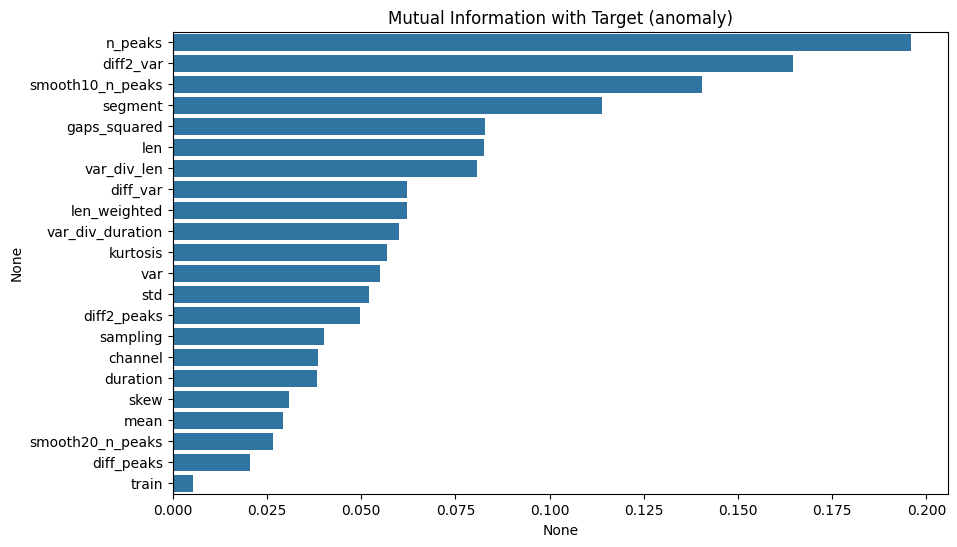

In [79]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop(columns=['anomaly'])
y = df['anomaly']

import numpy as np
X = X.select_dtypes(include=[np.number])  # mutual_info needs numeric
mi_scores = mutual_info_classif(X, y, discrete_features='auto')
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=mi_series, y=mi_series.index)
plt.title("Mutual Information with Target (anomaly)")
plt.show()


sometimes there is 95%normal and 5% amonaly, so while dividing training and test dat , stratifiedkfold ensures that this ratio is maintained and imbalanec is not creating while dividing data

In [80]:
from sklearn.model_selection import StratifiedKFold
selected_features = ['n_peaks', 'diff2_var', 'smooth10_n_peaks', 'var_div_len','diff2_peaks','gaps_squared']
X = df[selected_features]
y = df['anomaly']

skf=StratifiedKFold(n_splits=5, random_state=None)
for train_index,test_index in skf.split(X,y):
    x1_train,x1_test=X.iloc[train_index],X.iloc[test_index]
    y1_train,y1_test=y.iloc[train_index],y.iloc[test_index]
    train_0, train_1 = len(y1_train[y1_train==0]), len(y1_train[y1_train==1])
    test_0, test_1 = len(y1_test[y1_test==0]), len(y1_test[y1_test==1])
    print('train: 0=%d, 1=%d, Test: 0=%d, 1=%d' % (train_0, train_1, test_0, test_1))

train: 0=1351, 1=347, Test: 0=338, 1=87
train: 0=1351, 1=347, Test: 0=338, 1=87
train: 0=1351, 1=347, Test: 0=338, 1=87
train: 0=1352, 1=347, Test: 0=337, 1=87
train: 0=1351, 1=348, Test: 0=338, 1=86


in the above output 0 mean normal and 1 meaning anomalous, and 1351 is count of normal in training data and 347 is count of non anomalous in train,
similarly for test dataset.

In [81]:
df.drop('segment',inplace=True,axis=1)

In [82]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

The train_test_split() function randomly shuffles and splits the dataset. Without setting a random_state, you'll get different splits every time you run the code.
By setting a specific random_state (like 42), you make the results deterministic — i.e., you'll always get the same train/test split when you run it.

In [84]:
import lightgbm as lgb
model_lgb = lgb.LGBMClassifier(random_state=42)
model_lgb.fit(X_train, y_train, categorical_feature='auto')


[LightGBM] [Info] Number of positive: 346, number of negative: 1352
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 890
[LightGBM] [Info] Number of data points in the train set: 1698, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.203769 -> initscore=-1.362901
[LightGBM] [Info] Start training from score -1.362901


LGBMClassifier(random_state=42)

In [85]:
y_pred=model_lgb.predict(X_test)
print(classification_report(y_test,y_pred))
print(confusion_matrix(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       337
           1       0.96      0.84      0.90        88

    accuracy                           0.96       425
   macro avg       0.96      0.92      0.94       425
weighted avg       0.96      0.96      0.96       425

[[334   3]
 [ 14  74]]


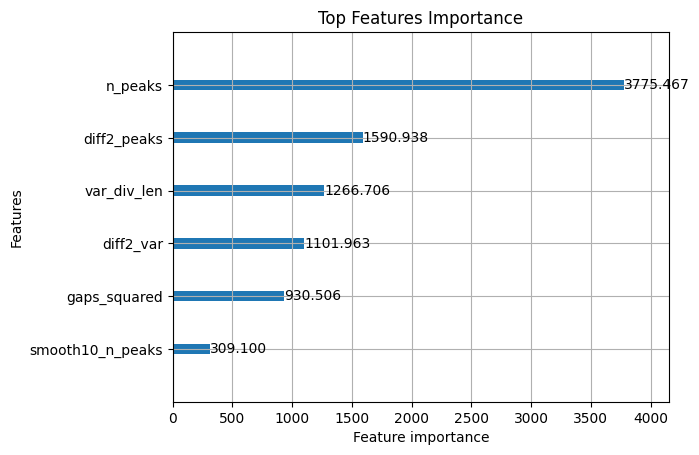

In [86]:
lgb.plot_importance(model_lgb,max_num_features=15,importance_type='gain')
plt.title("Top Features Importance")
plt.show()

<Axes: >

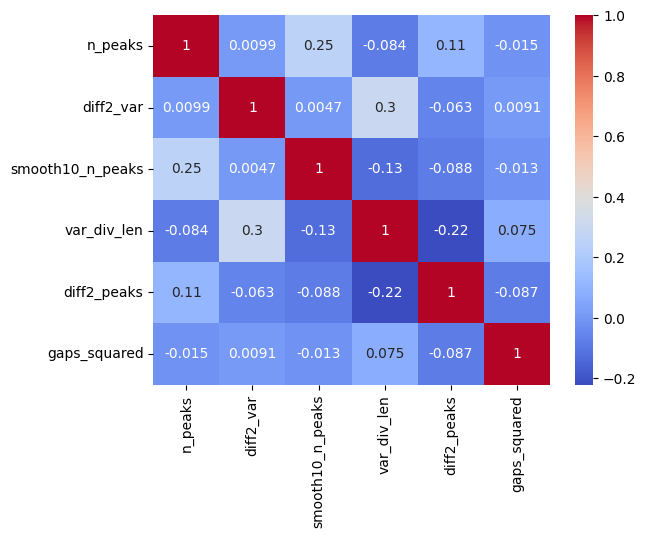

In [87]:
sns.heatmap(X.corr(),annot=True,cmap='coolwarm')

In [90]:
from sklearn.metrics import accuracy_score
lgb_acc=accuracy_score(y_pred,y_test)
print("Accuracy score: ",lgb_acc)
print("Matthews corelation coefficient",matthews_corrcoef(y_pred,y_test))

Accuracy score:  0.96
Matthews corelation coefficient 0.8752825883955407


In [91]:
from xgboost import XGBClassifier
xgb=OutputCodeClassifier(XGBClassifier(random_state=42),random_state=42)
xgb.fit(X_train,y_train)

OutputCodeClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=None, max_bin=None,
                                             max_cat_threshold=None,
                                             max_cat_to_onehot=None,
                                             max_delta_step=None,
                                             max_depth=None, max_leaves=None,
                                             min_child_weight=None, missing=nan,
                                             monotone_constraints=None,
                                             multi_strategy=None,
                                             n_estimators=None, n_jobs=None,
                                             num_parallel_tree=None,
                                             random_state=42, ...),
                     random_state=42)

In [92]:
y_pred_xgb=xgb.predict(X_test)
print(xgb)


OutputCodeClassifier(estimator=XGBClassifier(base_score=None, booster=None,
                                             callbacks=None,
                                             colsample_bylevel=None,
                                             colsample_bynode=None,
                                             colsample_bytree=None, device=None,
                                             early_stopping_rounds=None,
                                             enable_categorical=False,
                                             eval_metric=None,
                                             feature_types=None, gamma=None,
                                             grow_policy=None,
                                             importance_type=None,
                                             interaction_constraints=None,
                                             learning_rate=None, max_bin=None,
                                             max_cat_threshold=None,
        

In [93]:
print(classification_report(y_test,y_pred_xgb))
print(confusion_matrix(y_test,y_pred_xgb))

              precision    recall  f1-score   support

           0       0.96      0.99      0.98       337
           1       0.96      0.84      0.90        88

    accuracy                           0.96       425
   macro avg       0.96      0.92      0.94       425
weighted avg       0.96      0.96      0.96       425

[[334   3]
 [ 14  74]]


In [94]:
xgb_acc=accuracy_score(y_test,y_pred_xgb)
print("Accuracy Score: ",xgb_acc)
print("Matthews correlation coefficient: %.4f" %(matthews_corrcoef(y_test,y_pred_xgb)))


Accuracy Score:  0.96
Matthews correlation coefficient: 0.8753


In [95]:
if lgb_acc>xgb_acc:
  bestmodel=model_lgb
else:
  bestmodel=xgb

In [96]:
import joblib
joblib.dump(bestmodel, 'bestmodel.pkl')


['bestmodel.pkl']